<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Обучение-и-тест" data-toc-modified-id="Обучение-и-тест-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тест</a></span><ul class="toc-item"><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тест" data-toc-modified-id="Тест-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Тест</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

## Подготовка

Произведем импорт необходимых модулей и функций.

In [1]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import re
import seaborn as sns

from catboost import CatBoostClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle

Далее, загрузим исходные данные и оснакомимся с ними.

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


Теперь проверим, насколько сбалансированны классы в исходной выборке.

<AxesSubplot:title={'center':'Баланс классов'}, xlabel='toxic', ylabel='count'>

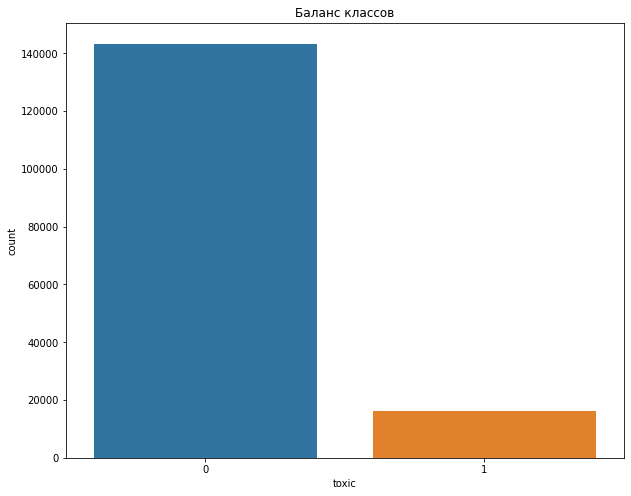

In [5]:
fig , ax1 = plt.subplots(figsize=(10,8))
plt.title('Баланс классов')
sns.countplot(x='toxic', data=df, ax=ax1)

Судя по графику, классы не сбалансированы, необходимо будет это исправить методом upsampling.

## Предобработка данных

Подготовим функцию, которая:

1. Приведет текст к нижнему регистру;
2. Удалит их текста все символы кроме латинских фукв и цифр;
3. Лемматизирует текст;
4. Вернёт обработанный текст;

In [6]:
nltk.download('wordnet')
nlm = WordNetLemmatizer()
def lemm(text):
    text = text.lower()
    clear_text = re.sub(r"[^a-z]", ' ', text)
    lemmatize_text = ''.join(nlm.lemmatize(clear_text.split()))
    return ' '.join(lemmatize_text.split())

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Прогоним через созданную функцию, исходные данные.

In [7]:
df['text'] = df['text'].apply(lemm)
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he matches this background colour i m se...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestions on impr...,0
4,you sir are my hero any chance you remember wh...,0


Теперь, разделим исходный датасет на тренировочный и тестовый, в тренировочном датасете выровним баланс классом методом upsampling.

In [8]:
train, test = train_test_split(df, random_state=123, test_size=0.2)

dop_row = train.query('toxic == 1')
train = pd.concat([train] + [dop_row]*2)

train = shuffle(train)

Посмотрим как исменился баланс классов.

In [9]:
list_data = [
    [len(df.query('toxic == 1'))/df.shape[0] * 100, len(df.query('toxic == 0'))/df.shape[0] * 100],
    [len(train.query('toxic == 1'))/ train.shape[0] * 100, len(train.query('toxic == 0'))/ train.shape[0] * 100],
]

data = pd.DataFrame(data=list_data, columns=['% toxic_1', ' % toxic_0'], index=['Исходный фрейм', 'Сбалансированный'])
data

,% toxic_1,% toxic_0
Исходный фрейм,10.167888,89.832112
Сбалансированный,25.498049,74.501951


Теперь разделим датасеты на признаки и целевой показатель.

In [32]:
features_train = train.text
target_train = train.toxic

features_test = test.text
target_test = test.toxic

Убедимся, что разделение прошло корректно.

In [11]:
print(features_train.shape)
print(target_train.shape)

(153800,)
(153800,)


Подготовим векторизатор.

In [12]:
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=False)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Выводы

В ходе предобработки, мы подготовили исходные тексты к векторизации, путим приведения в нижний регистр, очистки от лишниз символов и лемматизации. Далее, мы выровнили баланс классов (в тренировочной выборке) и векторизировали текст.

## Обучение и тест

### Обучение

Подготовим переменные для поиска оптимальных параметров у разных моделей с учетом верторизации текстов.

Обучим разные модели, с разными гипперпараметрами, выберем модель, которая покажет наилучший результат на тренировочной выборке.



In [23]:
tree_mod = DecisionTreeClassifier(random_state=123)
forest_mod = RandomForestClassifier(random_state=123)
log_mod = LogisticRegression(random_state=123, class_weight='balanced')
cat_mod = CatBoostClassifier(random_state=123, auto_class_weights='Balanced', iterations=100)

step_tree = [('normalizer', tf_idf), ('classifier', tree_mod)]
step_forest = [('normalizer', tf_idf), ('classifier', forest_mod)]
step_log = [('normalizer', tf_idf), ('classifier', log_mod)]
step_cat = [('normalizer', tf_idf), ('classifier', cat_mod)]

pr_tree = {
   'classifier__criterion':['gini', 'entropy'],        
   'classifier__max_depth':list(range(1,15,5)) 
}
pr_forest = {
    'classifier__max_depth': list(range(5,15,5)),
    'classifier__n_estimators': [100, 200],
}
pr_log = {
    'classifier__solver': ['newton-cg', 'liblinear', 'sag'],
    'classifier__max_iter': [100, 150]
}
pr_cat = {}

In [18]:
pipe = Pipeline(step_tree)
tree_gs = GridSearchCV(
    estimator=pipe, scoring='f1', param_grid=pr_tree, cv=3, n_jobs=-1, verbose=True).fit(features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [19]:
print(tree_gs.best_score_)
print(tree_gs.best_params_)

0.6164761871724725
{'classifier__criterion': 'gini', 'classifier__max_depth': 11}


In [20]:
pipe = Pipeline(step_forest)
forest_gs = GridSearchCV(
    estimator=pipe, scoring='f1', param_grid=pr_forest, cv=3, n_jobs=-1, verbose=True).fit(features_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [21]:
print(forest_gs.best_score_)
print(forest_gs.best_params_)

0.000560796613603792
{'classifier__max_depth': 10, 'classifier__n_estimators': 200}


In [24]:
pipe = Pipeline(step_log)
log_gs = GridSearchCV(
    estimator=pipe, scoring='f1', param_grid=pr_log, cv=3, n_jobs=-1, verbose=True).fit(features_train, target_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


In [25]:
print(log_gs.best_params_)
print(log_gs.best_score_)

{'classifier__max_iter': 100, 'classifier__solver': 'liblinear'}
0.8937127194882072


In [26]:
pipe = Pipeline(step_cat)
cat_gs = GridSearchCV(
    estimator=pipe, scoring='f1', param_grid=pr_cat, cv=3, n_jobs=-1, verbose=True).fit(features_train, target_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Learning rate set to 0.5
0:	learn: 0.5657586	total: 2.51s	remaining: 4m 8s
1:	learn: 0.5233795	total: 4.4s	remaining: 3m 35s
2:	learn: 0.4962126	total: 6.28s	remaining: 3m 22s
3:	learn: 0.4756709	total: 8.11s	remaining: 3m 14s
4:	learn: 0.4613998	total: 9.99s	remaining: 3m 9s
5:	learn: 0.4472555	total: 11.8s	remaining: 3m 4s
6:	learn: 0.4345586	total: 13.7s	remaining: 3m 2s
7:	learn: 0.4230727	total: 15.6s	remaining: 2m 59s
8:	learn: 0.4135347	total: 17.4s	remaining: 2m 55s
9:	learn: 0.4059243	total: 19.2s	remaining: 2m 52s
10:	learn: 0.4001978	total: 21s	remaining: 2m 49s
11:	learn: 0.3940492	total: 22.8s	remaining: 2m 47s
12:	learn: 0.3889794	total: 24.7s	remaining: 2m 45s
13:	learn: 0.3838794	total: 26.5s	remaining: 2m 42s
14:	learn: 0.3791186	total: 28.4s	remaining: 2m 40s
15:	learn: 0.3749241	total: 30.2s	remaining: 2m 38s
16:	learn: 0.3708595	total: 32s	remaining: 2m 36s
17:	learn: 0.3675482	total: 33.8s	remaining: 2m 34s

In [27]:
print(cat_gs.best_score_)
print(cat_gs.best_params_)

0.8571107462900436
{}


In [28]:
list_data = [tree_gs.best_score_, forest_gs.best_score_, log_gs.best_score_, cat_gs.best_score_]
data = pd.DataFrame(data=list_data, index=['tree', 'forest', 'logres', 'catboost'], columns=['f1_score'])
display(data.sort_values('f1_score', ascending=False))

,f1_score
logres,0.893713
catboost,0.857111
tree,0.616476
forest,0.000561


Наилучшим образом показала себя модель логистической регрессии. Выберем её для теста.

### Тест

Проверим, как поведет себя модель на тестовой выборке.

In [33]:
tf_idf = TfidfVectorizer(stop_words=stopwords, lowercase=False)

features_train = tf_idf.fit_transform(features_train)
features_test = tf_idf.transform(features_test)

In [34]:
model = LogisticRegression(random_state=123, solver='liblinear')
model.fit(features_train, target_train)
print(f1_score(model.predict(features_test), target_test))

0.7820321564727334


## Выводы

В ходе работы, была проведена предобработка текстовых данных, был выровнен баланс классов и обычены различные модели классификации. Наилучшим образом показала себ модель логистической регрессии. При проверке на тестовой выборке, необходимый порог был пройдет, задача выполнена.